In [1]:
import time
import os

# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch
import pytorch3d.ops
from plyfile import PlyData, PlyElement
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from argparse import ArgumentParser, Namespace
import cv2

from arguments import ModelParams, PipelineParams
from scene import Scene, GaussianModel, FeatureGaussianModel
from gaussian_renderer import render, render_contrastive_feature

from segment_anything import (SamAutomaticMaskGenerator, SamPredictor,
                              sam_model_registry)
from utils.sh_utils import SH2RGB

def get_combined_args(parser : ArgumentParser, model_path, target_cfg_file = None):
    cmdlne_string = ['--model_path', model_path]
    cfgfile_string = "Namespace()"
    args_cmdline = parser.parse_args(cmdlne_string)
    
    if target_cfg_file is None:
        if args_cmdline.target == 'seg':
            target_cfg_file = "seg_cfg_args"
        elif args_cmdline.target == 'scene':
            target_cfg_file = "cfg_args"
        elif args_cmdline.target == 'feature' or args_cmdline.target == 'contrastive_feature' :
            target_cfg_file = "feature_cfg_args"

    try:
        cfgfilepath = os.path.join(model_path, target_cfg_file)
        print("Looking for config file in", cfgfilepath)
        with open(cfgfilepath) as cfg_file:
            print("Config file found: {}".format(cfgfilepath))
            cfgfile_string = cfg_file.read()
    except TypeError:
        print("Config file found: {}".format(cfgfilepath))
        pass
    args_cfgfile = eval(cfgfile_string)

    merged_dict = vars(args_cfgfile).copy()
    for k,v in vars(args_cmdline).items():
        if v != None:
            merged_dict[k] = v

    return Namespace(**merged_dict)

def load_point_colors_from_pcd(num_points, path):
    plydata = PlyData.read(path)

    features_dc = np.zeros((num_points, 3))
    features_dc[:, 0] = np.asarray(plydata.elements[0]["f_dc_0"])
    features_dc[:, 1] = np.asarray(plydata.elements[0]["f_dc_1"])
    features_dc[:, 2] = np.asarray(plydata.elements[0]["f_dc_2"])

    colors = SH2RGB(features_dc)

    # N, 3
    return torch.clamp(torch.from_numpy(colors).squeeze().cuda(), 0.0, 1.0) * 255.

def write_ply(save_path, points, colors = None, normals = None, text=True):
    """
    save_path : path to save: '/yy/XX.ply'
    pt: point_cloud: size (N,3)
    """
    assert colors is None or normals is None, "Cannot have both colors and normals"
    
    if colors is None and normals is None:
        points = [(points[i,0], points[i,1], points[i,2]) for i in range(points.shape[0])]
        vertex = np.array(points, dtype=[('x', 'f4'), ('y', 'f4'),('z', 'f4')])
    elif colors is not None:
        dtype_full = [('x', 'f4'), ('y', 'f4'), ('z', 'f4'), ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')]
        points = [(points[i,0], points[i,1], points[i,2], colors[i,0], colors[i,1], colors[i,2]) for i in range(points.shape[0])]
        vertex = np.array(points, dtype=dtype_full)
    else:
        dtype_full = [('x', 'f4'), ('y', 'f4'), ('z', 'f4'), ('normal_x', 'f4'), ('normal_y', 'f4'), ('normal_z', 'f4')]
        points = [(points[i,0], points[i,1], points[i,2], normals[i,0], normals[i,1], normals[i,2]) for i in range(points.shape[0])]
        vertex = np.array(points, dtype=dtype_full)

    el = PlyElement.describe(vertex, 'vertex', comments=['vertices'])
    PlyData([el], text=text).write(save_path)
    
def write_ply_with_color(save_path, points, colors, text=True):
    dtype_full = [('x', 'f4'), ('y', 'f4'), ('z', 'f4'), ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')]
    points = [(points[i,0], points[i,1], points[i,2], colors[i,0], colors[i,1], colors[i,2]) for i in range(points.shape[0])]
    vertex = np.array(points, dtype=dtype_full)
    el = PlyElement.describe(vertex, 'vertex', comments=['vertices'])
    PlyData([el], text=text).write(save_path)
    
def postprocess_statistical_filtering(pcd, precomputed_mask = None, max_time = 5):
    
    if type(pcd) == np.ndarray:
        pcd = torch.from_numpy(pcd).cuda()
    else:
        pcd = pcd.cuda()

    num_points = pcd.shape[0]
    # (N, P1, K)

    std_nearest_k_distance = 10
    
    while std_nearest_k_distance > 0.1 and max_time > 0:
        nearest_k_distance = pytorch3d.ops.knn_points(
            pcd.unsqueeze(0),
            pcd.unsqueeze(0),
            K=int(num_points**0.5),
        ).dists
        mean_nearest_k_distance, std_nearest_k_distance = nearest_k_distance.mean(), nearest_k_distance.std()
        print(std_nearest_k_distance, "std_nearest_k_distance")

        mask = nearest_k_distance.mean(dim = -1) < mean_nearest_k_distance + std_nearest_k_distance

        mask = mask.squeeze()

        pcd = pcd[mask,:]
        if precomputed_mask is not None:
            precomputed_mask[precomputed_mask != 0] = mask
        max_time -= 1
        
    return pcd.squeeze(), nearest_k_distance.mean(), precomputed_mask

def postprocess_grad_based_statistical_filtering(pcd, precomputed_mask, feature_gaussians, view, sam_mask, pipeline_args):
    start_time = time.time()
    
    background = torch.zeros(feature_gaussians.get_opacity.shape[0], 3, device = 'cuda')

    grad_catch_mask = torch.zeros(feature_gaussians.get_opacity.shape[0], 1, device = 'cuda')
    grad_catch_mask[precomputed_mask, :] = 1
    grad_catch_mask.requires_grad = True

    grad_catch_2dmask = render(
        view, 
        feature_gaussians, 
        pipeline_args, 
        background,
        filtered_mask=~precomputed_mask, 
        override_color=torch.zeros(feature_gaussians.get_opacity.shape[0], 3, device = 'cuda'),
        override_mask=grad_catch_mask,
        )['mask']


    target_mask = torch.tensor(sam_mask, device=grad_catch_2dmask.device)
    target_mask = torch.nn.functional.interpolate(target_mask.unsqueeze(0).unsqueeze(0).float(), size=grad_catch_2dmask.shape[-2:] , mode='bilinear').squeeze(0).repeat([3,1,1])
    target_mask[target_mask > 0.5] = 1
    target_mask[target_mask != 1] = 0

    loss = -(target_mask * grad_catch_2dmask).sum() + 10 * ((1-target_mask)* grad_catch_2dmask).sum()
    loss.backward()

    grad_score = grad_catch_mask.grad[precomputed_mask != 0].clone().squeeze()
    grad_score = -grad_score
    
    pos_grad_score = grad_score.clone()
    pos_grad_score[pos_grad_score <= 0] = 0
    pos_grad_score[pos_grad_score <= pos_grad_score.mean() + pos_grad_score.std()] = 0
    pos_grad_score[pos_grad_score != 0] = 1

    confirmed_mask = pos_grad_score.bool()

    if type(pcd) == np.ndarray:
        pcd = torch.from_numpy(pcd).cuda()
    else:
        pcd = pcd.cuda()

    confirmed_point = pcd[confirmed_mask == 1]

    confirmed_point, _, _ = postprocess_statistical_filtering(confirmed_point, max_time=5)

    test_nearest_k_distance = pytorch3d.ops.knn_points(
        confirmed_point.unsqueeze(0),
        confirmed_point.unsqueeze(0),
        K=2,
    ).dists
    mean_nearest_k_distance, std_nearest_k_distance = test_nearest_k_distance[:,:,1:].mean(), test_nearest_k_distance[:,:,1:].std()
    test_threshold = torch.max(test_nearest_k_distance)
    print(test_threshold, "test threshold")

    while True:

        nearest_k_distance = pytorch3d.ops.knn_points(
            pcd.unsqueeze(0),
            confirmed_point.unsqueeze(0),
            K=1,
        ).dists
        mask = nearest_k_distance.mean(dim = -1) <= test_threshold
        mask = mask.squeeze()
        true_mask = mask
        if torch.abs(true_mask.count_nonzero() - confirmed_point.shape[0]) / confirmed_point.shape[0] < 0.001:
            break

        confirmed_point = pcd[true_mask,:]

    precomputed_mask[precomputed_mask == 1] = true_mask
        
    print(time.time() - start_time)
    return confirmed_point.squeeze().detach().cpu().numpy(), precomputed_mask, test_threshold
    
def postprocess_growing(original_pcd, point_colors, seed_pcd, seed_point_colors, thresh = 0.05, grow_iter = 1):
    s_time = time.time()
    min_x, min_y, min_z = seed_pcd[:,0].min(), seed_pcd[:,1].min(), seed_pcd[:,2].min()
    max_x, max_y, max_z = seed_pcd[:,0].max(), seed_pcd[:,1].max(), seed_pcd[:,2].max()

    lx, ly, lz = max_x - min_x, max_y - min_y, max_z - min_z
    min_x, min_y, min_z = min_x - lx*0.05, min_y - ly*0.05, min_z - lz*0.05
    max_x, max_y, max_z = max_x + lx*0.05, max_y + ly*0.05, max_z + lz*0.05

    cutout_mask = (original_pcd[:,0] < max_x) * (original_pcd[:,1] < max_y) * (original_pcd[:,2] < max_z)
    cutout_mask *= (original_pcd[:,0] > min_x) * (original_pcd[:,1] > min_y) * (original_pcd[:,2] > min_z)
    
    cutout_point_cloud = original_pcd[cutout_mask > 0]

    for i in range(grow_iter):
        num_points_in_seed = seed_pcd.shape[0]
        res = pytorch3d.ops.ball_query(
            cutout_point_cloud.unsqueeze(0), 
            seed_pcd.unsqueeze(0),
            K=1,
            radius=thresh,
            return_nn=False
        ).idx

        mask = (res != -1).sum(-1) != 0

        mask = mask.squeeze()

        seed_pcd = cutout_point_cloud[mask, :]
    
    final_mask = cutout_mask.clone()
    final_mask[final_mask != 0] = mask > 0

    print(mask.count_nonzero())
    print(time.time() - s_time)

    return seed_pcd, final_mask, None

/home/yang/miniconda3/envs/gaussian_splatting/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Hyper-parameters

In [2]:
import os
FEATURE_DIM = 32

DATA_ROOT = '../data/plant2/'
# the model path, same to the --model_path in the training, after train_scene.py this folder will be created but named randomly
MODEL_PATH = './output/plant2_sam/'
# 'lego_real_night_radial'
SPIN_SCENE_NAME = 'plant2'
NVOS_SCENE_NAME = 'orchids'
FEATURE_GAUSSIAN_ITERATION = 30000

SAM_PROJ_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/sam_proj.pt')
NEG_PROJ_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/neg_proj.pt')
FEATURE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/contrastive_feature_point_cloud.ply')
SCENE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/scene_point_cloud.ply')

SAM_ARCH = 'vit_h'
SAM_CKPT_PATH = '../Grounded-Segment-Anything/checkpoints/sam_vit_h_4b8939.pth'

# Data and Model Preparation


In [21]:
nonlinear = torch.nn.Sequential(
    torch.nn.Linear(256, 64, bias=True),
    torch.nn.LayerNorm(64),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(64, 64, bias=True),
    torch.nn.LayerNorm(64),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(64, FEATURE_DIM, bias=True),
)
nonlinear.load_state_dict(torch.load(SAM_PROJ_PATH))
nonlinear = nonlinear.cuda()
nonlinear.eval()

parser = ArgumentParser(description="Testing script parameters")
model = ModelParams(parser, sentinel=True)
pipeline = PipelineParams(parser)
parser.add_argument("--iteration", default=30000, type=int)
parser.add_argument("--skip_train", action="store_true")
parser.add_argument("--skip_test", action="store_true")
parser.add_argument("--quiet", action="store_true")
parser.add_argument("--segment", action="store_true")
parser.add_argument('--target', default='scene', const='scene', nargs='?', choices=['scene', 'seg', 'feature', 'coarse_seg_everything', 'contrastive_feature', 'xyz'])
parser.add_argument('--idx', default=0, type=int)
parser.add_argument('--precomputed_mask', default=None, type=str)

args = get_combined_args(parser, MODEL_PATH)

dataset = model.extract(args)
dataset.need_features = False
dataset.need_masks = True

feature_gaussians = FeatureGaussianModel(FEATURE_DIM)

scene = Scene(dataset, None, feature_gaussians, load_iteration=-1, feature_load_iteration=FEATURE_GAUSSIAN_ITERATION, shuffle=False, mode='eval', target='contrastive_feature')

xyz = feature_gaussians.get_xyz
point_features = feature_gaussians.get_point_features.cuda()
feature_gaussians._xyz.shape

Looking for config file in ./output/plant2_sam/cfg_args
Config file found: ./output/plant2_sam/cfg_args
Loading trained model at iteration -1, 30000
Reading camera 119/119
Loading Training Cameras
Loading Test Cameras


torch.Size([795603, 3])

In [22]:
model_type = SAM_ARCH
sam = sam_model_registry[model_type](checkpoint=SAM_CKPT_PATH).to('cuda')
predictor = SamPredictor(sam)

# Begin Segmenting

In [23]:
cameras = scene.getTrainCameras()
print("There are",len(cameras),"views in the dataset.")

There are 119 views in the dataset.


153.5241825580597


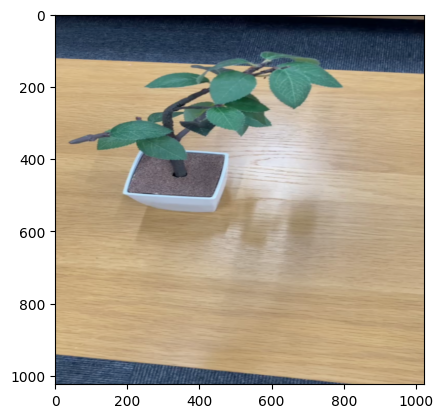

In [25]:
ref_img_camera_id = 0
mask_img_camera_id = 0

view = cameras[ref_img_camera_id]
img = view.original_image * 255
img = cv2.resize(img.permute([1,2,0]).detach().cpu().numpy().astype(np.uint8),dsize=(1024,1024),fx=1,fy=1,interpolation=cv2.INTER_LINEAR)
predictor.set_image(img)
sam_feature = predictor.features # sam feature 
# sam_feature = view.original_features

start_time = time.time()
bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_feature = render_contrastive_feature(view, feature_gaussians, pipeline.extract(args), background)['render']
time1 = time.time() - start_time

H, W = sam_feature.shape[-2:]

print(time1)
plt.imshow(img)

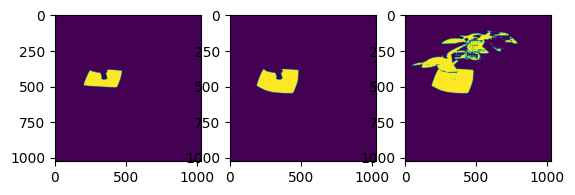

In [27]:
# input_point = np.array([[820, 580], [400, 500]])
# input_point = np.array([[300, 400], [600, 700]])
# input_point = np.array([[800, 600]])
# trex part
# input_point = np.array([[650, 670], [650, 800]])
# orchids part
# input_point = np.array([[520, 550]])
# kitchen part
# input_point = np.array([[600, 620]])
# chesstable
# input_point = np.array([[400, 600], [400, 800], [280, 650]])
# garden
# input_point = np.array([[520, 400], [550, 300]])

input_point = np.array([[250, 400]])
input_label = np.ones(len(input_point))

with torch.no_grad():
    vanilla_masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,
    )


plt.subplot(1,3,1)
plt.imshow(vanilla_masks[0])
plt.subplot(1,3,2)
plt.imshow(vanilla_masks[1])
plt.subplot(1,3,3)
plt.imshow(vanilla_masks[2])

masks = torch.nn.functional.interpolate(torch.from_numpy(vanilla_masks).float().unsqueeze(0), (64,64), mode='bilinear').squeeze(0).cuda()
masks[masks > 0.5] = 1
masks[masks != 1] = 0

In [8]:
mask_id = 2
origin_ref_mask = torch.tensor(vanilla_masks[mask_id]).float().cuda()

if origin_ref_mask.shape != (64,64):
    ref_mask = torch.nn.functional.interpolate(origin_ref_mask[None, None, :, :], (64,64), mode='bilinear').squeeze().cuda()
    ref_mask[ref_mask > 0.5] = 1
    ref_mask[ref_mask != 1] = 0
else:
    ref_mask = origin_ref_mask
# sam features
start_time = time.time()

low_dim_features = nonlinear(
    sam_feature.view(-1, H*W).permute([1,0])
).squeeze().permute([1,0]).reshape([-1, H, W])

# SAM query
mask_low_dim_features = ref_mask.unsqueeze(0) * torch.nn.functional.interpolate(low_dim_features.unsqueeze(0), ref_mask.shape[-2:], mode = 'bilinear').squeeze()
mask_pooling_prototype = mask_low_dim_features.sum(dim = (1,2)) / torch.count_nonzero(ref_mask)

# Feature Field query
# mask_low_dim_features = ref_mask.unsqueeze(0) * torch.nn.functional.interpolate(rendered_feature.unsqueeze(0), ref_mask.shape[-2:], mode = 'bilinear').squeeze()
# mask_pooling_prototype = mask_low_dim_features.sum(dim = (1,2)) / torch.count_nonzero(ref_mask)

time2 = time.time() - start_time
print(time2)


0.0013401508331298828


In [9]:
import kmeans_pytorch
import importlib
importlib.reload(kmeans_pytorch)
from kmeans_pytorch import kmeans

# K-means or not

start_time = time.time()

bg_color = [0 for i in range(32)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_feature = render_contrastive_feature(view, feature_gaussians, pipeline.extract(args), background)['render']

similarity_mask = torch.einsum('C,CHW->HW', mask_pooling_prototype.cuda(), rendered_feature)
similarity_mask = torch.nn.functional.interpolate(similarity_mask.float().unsqueeze(0).unsqueeze(0), (64,64), mode='bilinear').squeeze().cuda()
similarity_mask[similarity_mask > 0] = 1
similarity_mask[similarity_mask != 1] = 0

iob = (similarity_mask * ref_mask).sum(dim = (-1, -2)) / ref_mask.sum()

if iob > 0.9:
    fmask_prototype = mask_pooling_prototype.unsqueeze(0)
else:

    downsampled_masks = torch.nn.functional.adaptive_avg_pool2d(ref_mask.unsqueeze(0).unsqueeze(0), (8,8)).squeeze()
    downsampled_features = torch.nn.functional.adaptive_avg_pool2d(mask_low_dim_features.unsqueeze(0), (8,8)).squeeze(0)
    downsampled_features /= downsampled_masks.unsqueeze(0)

    downsampled_masks[downsampled_masks != 0]= 1
    init_prototypes = downsampled_features[:, downsampled_masks.bool()].permute([1,0])


    masked_sam_features = low_dim_features[:, ref_mask.bool()]
    masked_sam_features = masked_sam_features.permute([1,0])

    num_clusters = init_prototypes.shape[0]
    print(num_clusters)
    if num_clusters <= 1:
        num_clusters = min(int(masked_sam_features.shape[0] ** 0.5), 32)
        init_prototypes = []

    cluster_ids_x, cluster_centers = kmeans(
        X=masked_sam_features, num_clusters=num_clusters, cluster_centers=init_prototypes, distance='cosine', device=torch.device('cuda')
    )

    similarity_mask = torch.sigmoid(torch.einsum('NC,CHW->NHW', cluster_centers.cuda(), rendered_feature))
    similarity_mask = torch.nn.functional.interpolate(similarity_mask.float().unsqueeze(1), (64,64), mode='bilinear').squeeze().cuda()
    similarity_mask[similarity_mask >= 0.5] = 1
    similarity_mask[similarity_mask != 1] = 0
    similarity_mask = similarity_mask.squeeze()

    ioa = (similarity_mask * ref_mask[None,:,:]).sum(dim = (-1, -2)) / (similarity_mask.sum(dim = (-1, -2)) + 1e-5)
    iob = (similarity_mask * ref_mask[None,:,:]).sum(dim = (-1, -2)) / ref_mask.sum()

    ioa = ioa.squeeze()
    iob = iob.squeeze()
    cluster_mask = ioa > 0.75

    # NMS
    for i in range(len(cluster_mask)):
        if not cluster_mask[i]:
            continue

        for j in range(i+1, len(cluster_mask)):
            if not cluster_mask[j]:
                continue

            if (similarity_mask[j] * similarity_mask[i]).sum() / ((similarity_mask[j] + similarity_mask[i]).sum() - (similarity_mask[j] * similarity_mask[i]).sum()) > 0.75:
                if ioa[i] > ioa[j]:
                    cluster_mask[j] = False
                else:
                    cluster_mask[i] = False
                    break

    fmask_prototype = torch.cat([mask_pooling_prototype.unsqueeze(0), cluster_centers[cluster_mask, :].cuda()], dim = 0)

time3 = time.time() - start_time
print(time3)

0.007866621017456055


In [10]:
mask_prototype = fmask_prototype
start_time = time.time()
if mask_prototype.shape[0] == 1 or len(mask_prototype.shape) == 1:
    point_logits = torch.einsum('NC,C->N', point_features, mask_prototype.squeeze())
    point_scores = torch.sigmoid(point_logits)
else:
    point_logits = torch.einsum('NC,LC->NL', point_features, mask_prototype)
    point_logits = point_logits.max(-1)[0]
    point_scores = torch.sigmoid(point_logits)
two_d_point_logits = torch.einsum('NC,CHW->NHW', mask_prototype.cuda(), rendered_feature).max(dim = 0)[0]
two_d_point_logits = torch.nn.functional.interpolate(two_d_point_logits.float()[None, None, ...], ref_mask.shape[-2:], mode='bilinear').squeeze().cuda()
in_mask_logits = two_d_point_logits[ref_mask.bool()]

# Adjustable Threshold
thresh = max(max(in_mask_logits.mean() + in_mask_logits.std(), torch.topk(point_logits, int(point_logits.shape[0]*0.1))[0][-1]), 0)

mask = point_logits > thresh
torch.save(mask, 'output/segmentation_res/test_mask.pt')
print(torch.count_nonzero(mask))
time4 = time.time() - start_time
print(time4)

tensor(2025, device='cuda:0')
0.005318641662597656


In [11]:
start_time = time.time()
selected_xyz = xyz[mask.cpu()].data
selected_score = point_scores[mask.cpu()]
# write_ply('./segmentation_res/vanilla_seg.ply', selected_xyz)

selected_xyz, thresh, mask_ = postprocess_statistical_filtering(pcd=selected_xyz.clone(), precomputed_mask = mask.clone(), max_time=1)
filtered_points, filtered_mask, thresh = postprocess_grad_based_statistical_filtering(pcd=selected_xyz.clone(), precomputed_mask=mask_.clone(), feature_gaussians=feature_gaussians, view=view, sam_mask=ref_mask.clone(), pipeline_args=pipeline.extract(args))
# filtered_points, thresh = postprocess_statistical_filtering(pcd=selected_xyz.clone(), max_time=3)

# print(thresh)
# write_ply('./segmentation_res/filtered_seg.ply', filtered_points)
time5 = time.time() - start_time
print(time5)

tensor(14.1935, device='cuda:0') std_nearest_k_distance
tensor(2.4715, device='cuda:0') std_nearest_k_distance
tensor(0.6725, device='cuda:0') std_nearest_k_distance
tensor(0.1679, device='cuda:0') std_nearest_k_distance
tensor(0.1617, device='cuda:0') std_nearest_k_distance
tensor(0.7455, device='cuda:0') std_nearest_k_distance
tensor(0.2151, device='cuda:0') test threshold
0.022052764892578125
0.027476072311401367


/home/yang/miniconda3/envs/gaussian_splatting/lib/python3.7/site-packages/ipykernel_launcher.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [12]:
start_time = time.time()
final_xyz, point_mask, final_normals = postprocess_growing(xyz, None, torch.from_numpy(filtered_points).cuda(), None, max(thresh, 0.05), grow_iter = 1)

time6 = time.time() - start_time
print(time6)
torch.save(torch.logical_and(feature_gaussians.get_opacity.squeeze() > 0.1, point_mask.bool()), 'output/segmentation_res/pre_final_mask.pt')

tensor(123348, device='cuda:0')
0.00512385368347168
0.0054264068603515625


# Filter out the points confirmed to be negative

In [13]:
import gaussian_renderer
import importlib
importlib.reload(gaussian_renderer)

<module 'gaussian_renderer' from '/home/yang/projects/GaussianPlant/gaussian_renderer/__init__.py'>

In [14]:
start_time = time.time()

final_mask = point_mask.float().detach().clone().unsqueeze(-1)
final_mask.requires_grad = True

background = torch.zeros(final_mask.shape[0], 3, device = 'cuda')
rendered_mask_pkg = gaussian_renderer.render_mask(cameras[ref_img_camera_id], feature_gaussians, pipeline.extract(args), background, precomputed_mask=final_mask)

# print(rendered_mask_pkg['mask'].min(), rendered_mask_pkg['mask'].max())

tmp_target_mask = torch.tensor(origin_ref_mask, device=rendered_mask_pkg['mask'].device)
tmp_target_mask = torch.nn.functional.interpolate(tmp_target_mask.unsqueeze(0).unsqueeze(0).float(), size=rendered_mask_pkg['mask'].shape[-2:] , mode='bilinear').squeeze(0)
tmp_target_mask[tmp_target_mask > 0.5] = 1
tmp_target_mask[tmp_target_mask != 1] = 0

loss = 30*torch.pow(tmp_target_mask - rendered_mask_pkg['mask'], 2).sum()
loss.backward()

grad_score = final_mask.grad.clone()
final_mask = final_mask - grad_score
final_mask[final_mask < 0] = 0
final_mask[final_mask != 0] = 1
final_mask *= point_mask.unsqueeze(-1)

time7 = time.time() - start_time
print(time7)

torch.save(final_mask.bool(), 'output/segmentation_res/final_mask.pt')

final_xyz = xyz[final_mask.cpu().bool().squeeze(), ...].data

0.003184795379638672


/home/yang/miniconda3/envs/gaussian_splatting/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Time Cost: 0.0520787239074707


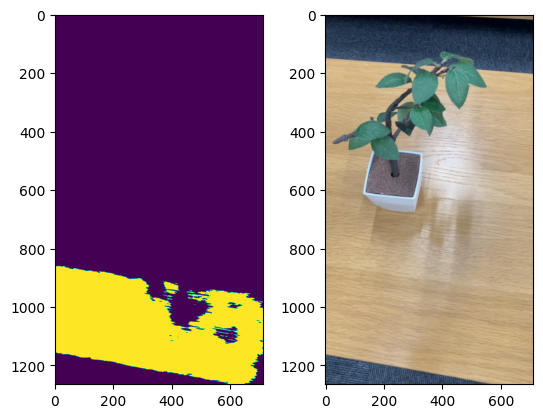

In [15]:
mask_img_camera_id = 0
rendered_mask_pkg = gaussian_renderer.render_mask(cameras[mask_img_camera_id], feature_gaussians, pipeline.extract(args), background, precomputed_mask=final_mask.float())
plt.subplot(1,2,1)
plt.imshow(rendered_mask_pkg['mask'].squeeze().detach().cpu() >= 0.5)
plt.subplot(1,2,2)
plt.imshow((cameras[mask_img_camera_id].original_image).permute([1,2,0]).cpu())

print("Time Cost:", time1 + time2 + time3 + time4 + time5 + time6 + time7)